In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pdb
import pandas as pd
import random
import shutil

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import models, transforms

# kornia imports
import kornia
import kornia.augmentation as K
import kornia.geometry.transform as T

from PIL import Image


c:\Users\Data_Science\anaconda3\envs\deep_learn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
preprocess = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor(),
])

# Data augmentation using Kornia
transform_train = K.AugmentationSequential(
        K.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.333)),
        K.RandomRotation(degrees=(-10, 10)),
        K.RandomHorizontalFlip(),
        K.RandomAffine(degrees=(0, 0), scale=(1.0, 1.1), shear=(0, 0)),  # Zoom
        K.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
        same_on_batch=False
)
transform_val_test = K.AugmentationSequential(
        K.CenterCrop(size=(224, 224)),
        K.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        same_on_batch=False
    )

In [4]:
def set_parameter_requires_grad(model, feature_extracting=False):

  if feature_extracting:
      # frozen model
      model.requires_grad_(False)
  else:
      # fine-tuning
      model.requires_grad_(True)

In [5]:
# for LoRA/DoRA
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        # rank: controls the inner dimension of the matrices A and B; controls the number of additional parameters introduced by LoRA,
        # a key factor in determining the balance between model adaptability and parameter efficiency.
        # alpha: a scaling hyper-parameter applied to the output of the low-rank adaptation,
        # controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted.

        self.use_dora = use_dora
        self.rank = rank  # low-rank
        self.alpha = alpha  # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))

        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T
            return F.linear(x, combined_weight, self.linear.bias)

In [6]:
# find linear layers in the model
def find_linear_layers(model):
    linear_layers = []
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            linear_layers.append(module)
        else:
            linear_layers.extend(find_linear_layers(module))
    return linear_layers

In [7]:
def replace_linear_with_dora_lora(model, rank, alpha, use_dora=True):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            # Create a new DoRALayer with the same dimensions
            in_features = module.in_features
            out_features = module.out_features
            if in_features > 10 and out_features > 10:
                # Replace the module with the LowRankLayer
                setattr(model, name,  LowRankLayer(module, rank, alpha, use_dora=use_dora))
        else:
            # Recursively apply this function to submodules
            replace_linear_with_dora_lora(module, rank, alpha, use_dora=use_dora)

In [8]:
def initialize_model(model_name = None, num_classes = 2, feature_extract = True, use_pretrained = True, DoRA = False, LoRA = False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model = None
    weights = 'DEFAULT' if use_pretrained else None
    input_size = 224
    rank, alpha = 4, 8
    if model_name == "mobile net 2" or model_name == "MN_v2":
        model = models.mobilenet_v2(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[1].in_features       # 1280
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)  # replace the last FC layer
        if DoRA or LoRA:
            use_dora = True if DoRA else False
            replace_linear_with_dora_lora(model, rank, alpha, use_dora=use_dora)
        
    elif model_name == "mobile net 3 large" or model_name == "MN_v3_l":
        model = models.mobilenet_v3_large(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[3].in_features       # 1280
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        if DoRA or LoRA:
            use_dora = True if DoRA else False
            replace_linear_with_dora_lora(model, rank, alpha, use_dora=use_dora)

    elif model_name == "mobile net 3 small" or model_name == "MN_v3_s":
        model = models.mobilenet_v3_small(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[3].in_features       # 1024
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        if DoRA or LoRA:
            use_dora = True if DoRA else False
            replace_linear_with_dora_lora(model, rank, alpha, use_dora=use_dora)

    elif model_name == "squeezenet" or model_name == "SQN": # just to show 1X1 convolutional replacement instead of fully connected
        model = models.squeezenet1_0(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        # no fully connected layers - no need to replace them to use DoRA/LoRA
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model.num_classes = num_classes
        
    elif model_name == "resnet50" or model_name == "RN50":
        model = models.resnet50(weights=weights)
        set_parameter_requires_grad(model, feature_extract)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        # no fully connected layers with a lot of parameters - no need to replace them to use DoRA/LoRA

    elif model_name == "vit base 16" or model_name == "VIT":     # visual transformer model
        model = models.vit_b_16(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.heads[0].in_features
        model.heads[0] = nn.Linear(num_ftrs, num_classes)
    else:
        raise NotImplementedError

    return model, input_size 

In [9]:
data_dir = r'C:\Users\Data_Science\Documents\GitHub\deep-learn-project\input\dataset'   # change to your directory
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class_names_bin = ['African', 'Asian']

# Define paths
test_data_dir = data_dir + r"\test"
train_data_dir = data_dir + r"\train"
validation_data_dir = data_dir + r"\validation"

# Split the data into training and validation sets
# Check if the directories exist
if os.path.exists(validation_data_dir):
    print("Validation directory is already exist. Pass to the next step.")
else:
    # check the train-test split ratio 
    test_files = 0
    train_files = 0
    total_files = 0
    for class_name in os.listdir(train_data_dir):
        class_dir = os.path.join(test_data_dir, class_name)
        test_files += len(os.listdir(class_dir))
        class_dir = os.path.join(train_data_dir, class_name)
        train_files += len(os.listdir(class_dir))
    total_files = test_files + train_files
    
    # Set splitting rates
    validation_split_in_total = 0.1
    train_split_in_total = train_files/total_files
    validation_split_in_train = validation_split_in_total/train_split_in_total
    
    # Iterate over the classes (African and Asian)
    for class_name in os.listdir(train_data_dir):
        class_dir = os.path.join(train_data_dir, class_name)
        
        # Ensure it's a directory
        if os.path.isdir(class_dir):
            # List all files in the class directory
            files = os.listdir(class_dir)
            class_files = len(files)
            percentage_class = class_files/train_files
            validation_split_in_train_class = validation_split_in_train
            
            # Shuffle the files randomly
            random.shuffle(files)
            
            # Calculate the number of validation samples
            num_validation_samples = int(len(files) * validation_split_in_train_class)
            
            # Split the files into training and validation sets
            validation_files = files[:num_validation_samples]
            training_files = files[num_validation_samples:]
            
            # Create destination directories if they don't exist
            os.makedirs(os.path.join(validation_data_dir, class_name), exist_ok=True)
            
            # Move validation files to validation directory
            for file_name in validation_files:
                src = os.path.join(class_dir, file_name)
                dst = os.path.join(validation_data_dir, class_name, file_name)
                shutil.move(src, dst)
        

cuda:0
Validation directory is already exist. Pass to the next step.


In [10]:
# Print data distribution
# count the number of files in all the subsets
total_files = 0
# count the number of files in each subset using a dictionary
subset_files = {}
for subset in os.listdir(data_dir):
    for class_path in class_names_bin:
        lst = os.listdir(os.path.join(data_dir, subset, class_path))
        no_files = len(lst)
        txt = "The {subset} set contains {no_files} images of {class_path} elephants."
        print(txt.format(subset=subset, no_files=no_files, class_path=class_path))
    subset_files[subset] = int(len(os.listdir(os.path.join(data_dir, subset, class_names_bin[0])))) + int(len(os.listdir(os.path.join(data_dir, subset, class_names_bin[1]))))
    total_files += subset_files[subset]

# print the total number of files
print("\nThe total number of images in the dataset is", total_files)
# print the number of files in each subset as a percentage of the total number of files
print("The train set contains %.2f%% of the images." % (100*subset_files["train"]/total_files))
print("The test set contains %.2f%% of the images." % (100*subset_files["test"]/total_files))
print("The validation set contains %.2f%% of the images." % (100*subset_files["validation"]/total_files))

The test set contains 97 images of African elephants.
The test set contains 91 images of Asian elephants.
The train set contains 369 images of African elephants.
The train set contains 369 images of Asian elephants.
The validation set contains 51 images of African elephants.
The validation set contains 51 images of Asian elephants.

The total number of images in the dataset is 1028
The train set contains 71.79% of the images.
The test set contains 18.29% of the images.
The validation set contains 9.92% of the images.


In [11]:
def create_dataloaders(batch_size = 32, data_dir = None):
    image_datasets = {x: ImageFolder(os.path.join(data_dir, x), transform=preprocess) for x in ['train', 'validation', 'test']}
    train_loader = DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=4)
    dataloaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    class_names = image_datasets['train'].classes
    return dataloaders, class_names


In [12]:
def apply_optimizer(model, feature_extract):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []  # override the initial list definition above
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
    # Observe that all parameters are being optimized
    optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    return optimizer

In [13]:
# training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    model = model.to(device)

    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    history = [train_loss, train_acc, val_loss, val_acc]


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # transform to tensor
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Kornia augmentation
                if phase == 'train':
                    inputs = transform_train(inputs)
                else:
                    inputs = transform_val_test(inputs)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # epoch statistics to numpy
            # epoch_loss = epoch_loss.numpy()
            epoch_acc = epoch_acc.cpu().numpy()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss), train_acc.append(epoch_acc)

                # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss.append(epoch_loss), val_acc.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    history = [train_loss, train_acc, val_loss, val_acc]

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, time_elapsed          # time in seconds




In [14]:
# plot and save the best model
def plot_test_results(hist, title = ""):

    epochs = len(hist[0])

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    axes[0].plot(range(1, epochs + 1), hist[0], label='Training')
    axes[0].plot(range(1, epochs + 1), hist[2], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Loss')
    axes[0].legend(loc='best')


    axes[1].plot(range(1, epochs + 1), hist[1], label='Training')
    axes[1].plot(range(1, epochs + 1), hist[3], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_title('Accuracy')
    axes[1].legend(loc='best')
    
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()


In [15]:
# MN_cnn_fe_models = ["mobile net 2", "mobile net 3 small", "mobile net 3 large", "squeezenet", "resnet50", "vit base 16"]
MN_cnn_fe_models = ["MN_v2_bs_32_ep_20_fe", 
                "MN_v3_s_bs_32_ep_20_fe", 
                "MN_v3_s_bs_64_ep_20_fe", 
                "MN_v3_s_bs_128_ep_20_fe",
                "MN_v3_l_bs_32_ep_20_fe",
                "RN50_bs_32_ep_20_fe",
                ]  # `fe` stands for `feature extraction', `ft` stands for `fine-tuning', `lora` stands for `LoRA', `dora` stands for `DoRA'

num_classes = 2
models_save_dir = r'C:\Users\Data_Science\Documents\GitHub\deep-learn-project\models_Kornia'      # change to your directory
histories_save_dir = r'C:\Users\Data_Science\Documents\GitHub\deep-learn-project\histories_Kornia'      # change to your directory

if not os.path.exists(models_save_dir):
    os.makedirs(models_save_dir)

if not os.path.exists(histories_save_dir):
    os.makedirs(histories_save_dir)
    
history_titles = ["train_loss", "train_acc", "val_loss", "val_acc"]

In [16]:
def train_and_save_model(model_descriptor):
    print("-------------------------------------------------------------------------------------------------------------------")
    print(f"Model descriptor: {model_descriptor}")
    print("\n")
    # Initialize the model for this run
    model_name = model_descriptor.split("_bs")[0]
    print(f"Model: {model_name}")
    batch_size = int(model_descriptor.split("_bs_")[1].split("_")[0])
    num_epochs = int(model_descriptor.split("_ep_")[1].split("_")[0])
    feature_extract = True if "fe" in model_descriptor else False
    DoRA = True if "dora" in model_descriptor else False
    LoRA = True if "lora" in model_descriptor else False

    model, input_size = initialize_model(model_name, num_classes=2, feature_extract=feature_extract, use_pretrained=True, DoRA=DoRA, LoRA=LoRA)
    print(f"Input size: {input_size}")
    print("\n")
    # Create the dataloaders
    dataloaders, class_names = create_dataloaders(batch_size=batch_size, data_dir=data_dir)

    # Send the model to device
    model = model.to(device)
    
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    optimizer = apply_optimizer(model, feature_extract)
    
    # Setup the loss fn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model, history, model_time = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

    model_save_name = "model_" + model_descriptor + ".pth"
    model_save_path = os.path.join(models_save_dir, model_save_name)
    torch.save(model.state_dict(), model_save_path)
    
    # save the history in csv file with titles: train_loss, train_acc, val_loss, val_acc
    history_save_name = "history_" + model_descriptor + "_" + str(model_time) + ".csv"
    history_save_path = os.path.join(histories_save_dir, history_save_name)
    history_dict = {title: history[i] for i, title in enumerate(history_titles)}
    history_dict_df = pd.DataFrame(history_dict)
    history_dict_df.to_csv(history_save_path, index=False)
    
    print(f"Model saved at: {model_save_path}")
    print("\n")
    print("-------------------------------------------------------------------------------------------------------------------")
    print("\n")
    return model, optimizer, history, dataloaders

### CNN Models with Feature Extraction:

In [17]:
best_cnn_fe_model = None
best_cnn_fe_model_descriptor = None
best_cnn_fe_model_optimizer = None
best_cnn_fe_accuracy = 0.0

# Train the models
for model_descriptor in MN_cnn_fe_models:
    model, optimizer, history, dataloaders = train_and_save_model(model_descriptor)
    val_acc = max(history[3])
    if best_cnn_fe_model is None:
        best_cnn_fe_model = model
        best_cnn_fe_model_descriptor = model_descriptor
        best_cnn_fe_model_optimizer = optimizer
        best_cnn_fe_accuracy = val_acc
        best_cnn_fe_dataloader = dataloaders
    else:
        # if validation accuracy is better than the previous best model, update the best model
        if val_acc > best_cnn_fe_accuracy:
            best_cnn_fe_model = model
            best_cnn_fe_model_descriptor = model_descriptor
            best_cnn_fe_model_optimizer = optimizer
            best_cnn_fe_accuracy = val_acc
            best_cnn_fe_history = history
            best_cnn_fe_dataloader = dataloaders

-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v2_bs_32_ep_20_fe


Model: MN_v2
Input size: 224


Params to learn:
	 classifier.1.weight
	 classifier.1.bias
Epoch 0/19
----------
train Loss: 0.7173 Acc: 0.4377
val Loss: 0.7053 Acc: 0.4706

Epoch 1/19
----------
train Loss: 0.6949 Acc: 0.5285
val Loss: 0.6877 Acc: 0.5392

Epoch 2/19
----------
train Loss: 0.6768 Acc: 0.5556
val Loss: 0.6776 Acc: 0.5490

Epoch 3/19
----------
train Loss: 0.6638 Acc: 0.6409
val Loss: 0.6577 Acc: 0.6275

Epoch 4/19
----------
train Loss: 0.6627 Acc: 0.6301
val Loss: 0.6574 Acc: 0.5980

Epoch 5/19
----------
train Loss: 0.6469 Acc: 0.6477
val Loss: 0.6471 Acc: 0.6275

Epoch 6/19
----------
train Loss: 0.6313 Acc: 0.6653
val Loss: 0.6494 Acc: 0.6078

Epoch 7/19
----------
train Loss: 0.6352 Acc: 0.6504
val Loss: 0.6312 Acc: 0.6569

Epoch 8/19
----------
train Loss: 0.6326 Acc: 0.6314
val Loss: 0.6293 Acc: 0.6471

Epoch 

### Best CNN Feature Extraction with LoRA and DoRA (if needed):

In [18]:
# check the best cnn model linear layers
use_lora_dora = False
linear_layers = find_linear_layers(best_cnn_fe_model)
print(f"Best CNN model: {best_cnn_fe_model_descriptor}")
print(f"Best CNN model linear layers: {linear_layers}")
# take out the in_features and out_features of the last linear layer
for layer in linear_layers:
    in_features = layer.in_features
    out_features = layer.out_features
    if in_features > 10 and out_features > 10:
        print("LoRA/DoRA can help in this layer")
        use_lora_dora = True
    else:
        print("LoRA/DoRA won't help much in this layer")
        

Best CNN model: MN_v3_l_bs_32_ep_20_fe
Best CNN model linear layers: [Linear(in_features=960, out_features=1280, bias=True), Linear(in_features=1280, out_features=2, bias=True)]
LoRA/DoRA can help in this layer
LoRA/DoRA won't help much in this layer


In [19]:
if use_lora_dora:
    best_cnn_fe_model_descriptor_with_lora = best_cnn_fe_model_descriptor + "_lora"
    best_cnn_fe_model_descriptor_with_dora = best_cnn_fe_model_descriptor + "_dora"

    # Train the best model with LoRA
    model_lora, optimizer_lora, history_lora, dataloaders_lora = train_and_save_model(best_cnn_fe_model_descriptor_with_lora)
    # Train the best model with DoRA
    model_dora, optimizer_dora, history_dora, dataloaders_dora = train_and_save_model(best_cnn_fe_model_descriptor_with_dora)

    # Check the best model with LoRA/DoRA
    val_acc_lora = max(history_lora[3])
    val_acc_dora = max(history_dora[3])
    if val_acc_lora > best_cnn_fe_accuracy and val_acc_lora > val_acc_dora:
        # LoRA is better
        best_cnn_fe_model = model_lora
        best_cnn_fe_model_descriptor = best_cnn_fe_model_descriptor_with_lora
        best_cnn_fe_model_optimizer = optimizer_lora
        best_cnn_fe_accuracy = val_acc_lora
        best_cnn_fe_history = history_lora
        best_cnn_fe_dataloader = dataloaders_lora
    elif val_acc_dora > best_cnn_fe_accuracy and val_acc_dora > val_acc_lora:
        # DoRA is better
        best_cnn_fe_model = model_dora
        best_cnn_fe_model_descriptor = best_cnn_fe_model_descriptor_with_dora
        best_cnn_fe_model_optimizer = optimizer_dora
        best_cnn_fe_accuracy = val_acc_dora
        best_cnn_fe_history = history_dora
        best_cnn_fe_dataloader = dataloaders_dora
else:
    print("skip LoRA/DoRA training on best CNN model")

-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_l_bs_32_ep_20_fe_lora


Model: MN_v3_l
Input size: 224


Params to learn:
	 classifier.0.A
	 classifier.0.B
	 classifier.3.weight
	 classifier.3.bias
Epoch 0/19
----------
train Loss: 0.7167 Acc: 0.5285
val Loss: 0.6960 Acc: 0.5294

Epoch 1/19
----------
train Loss: 0.6747 Acc: 0.5718
val Loss: 0.6539 Acc: 0.6373

Epoch 2/19
----------
train Loss: 0.6716 Acc: 0.5989
val Loss: 0.6543 Acc: 0.5784

Epoch 3/19
----------
train Loss: 0.6631 Acc: 0.6165
val Loss: 0.6194 Acc: 0.6961

Epoch 4/19
----------
train Loss: 0.6734 Acc: 0.6152
val Loss: 0.6323 Acc: 0.6275

Epoch 5/19
----------
train Loss: 0.6315 Acc: 0.6382
val Loss: 0.6009 Acc: 0.7059

Epoch 6/19
----------
train Loss: 0.6822 Acc: 0.6152
val Loss: 0.6589 Acc: 0.5686

Epoch 7/19
----------
train Loss: 0.6406 Acc: 0.6369
val Loss: 0.6319 Acc: 0.6373

Epoch 8/19
----------
train Loss: 0.6589 Acc: 

### MN_v3_l or MN_v3_s Feature Extraction with LoRA and DoRA, if not the best CNN models so far

In [20]:
best_cnn_fe_model_name = best_cnn_fe_model_descriptor.split("_bs")[0]
if "MN_v2" not in best_cnn_fe_model_name and "MN_v3" not in best_cnn_fe_model_name:
    # find the best model with "MN_v2" or "MN_v3" using the history 
    MN_v3_or_MN_v2_cnn_fe_model = None
    MN_v3_or_MN_v2_cnn_fe_model_descriptor = None
    MN_v3_or_MN_v2_cnn_fe_accuracy = 0.0
    for model_descriptor in MN_cnn_fe_models:
        if "MN_v2" in model_descriptor or "MN_v3" in model_descriptor:
            # check if the history file exists
            # find a file with the model descriptor in the histories directory
            history_file_name = [f for f in os.listdir(histories_save_dir) if model_descriptor in f][0]
            # show all files in the directory
            if history_file_name not in os.listdir(histories_save_dir):
                continue
            history_path = os.path.join(histories_save_dir, history_file_name)
            history_df = pd.read_csv(history_path)
            if history_df.empty:
                continue
            val_acc = max(history_df["val_acc"].values)
            if MN_v3_or_MN_v2_cnn_fe_model is None:
                MN_v3_or_MN_v2_cnn_fe_model = model_descriptor
                MN_v3_or_MN_v2_cnn_fe_accuracy = val_acc
                MN_v3_or_MN_v2_cnn_fe_model_descriptor = model_descriptor
                MN_v3_or_MN_v2_cnn_fe_dataloader = dataloaders
            if val_acc > MN_v3_or_MN_v2_cnn_fe_accuracy:
                MN_v3_or_MN_v2_cnn_fe_model = model_descriptor
                MN_v3_or_MN_v2_cnn_fe_accuracy = val_acc
                MN_v3_or_MN_v2_cnn_fe_model_descriptor = model_descriptor
                MN_v3_or_MN_v2_cnn_fe_dataloader = dataloaders

    print(f"MN_v3/MN_v2 best CNN model: {MN_v3_or_MN_v2_cnn_fe_model}")
    print(f"MN_v3/MN_v2 best CNN model descriptor: {MN_v3_or_MN_v2_cnn_fe_model_descriptor}")
    print(f"MN_v3/MN_v2 best CNN accuracy: {MN_v3_or_MN_v2_cnn_fe_accuracy}")
    
    # change the best one to LoRA/DoRA
    MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_lora = MN_v3_or_MN_v2_cnn_fe_model_descriptor + "_lora"
    MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_dora = MN_v3_or_MN_v2_cnn_fe_model_descriptor + "_dora"

    # Train the best one with LoRA
    model_lora, optimizer_lora, history_lora, dataloaders_lora = train_and_save_model(MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_lora)
    # Train the best one with DoRA
    model_dora, optimizer_dora, history_dora, dataloaders_dora = train_and_save_model(MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_dora)

    # Check the best one with LoRA/DoRA
    val_acc_dora = max(history_dora[3])
    val_acc_lora = max(history_lora[3])
    if val_acc_lora > best_cnn_fe_accuracy and val_acc_lora > val_acc_dora:
        # LoRA is better
        print("LoRA is better than DoRA for " + MN_v3_or_MN_v2_cnn_fe_model_descriptor)
        print("and it performs better than the best CNN model with feature extraction " + best_cnn_fe_model_descriptor)
        best_cnn_fe_model = model_lora
        best_cnn_fe_model_descriptor = MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_lora
        best_cnn_fe_model_optimizer = optimizer_lora
        best_cnn_fe_accuracy = val_acc_lora
        best_cnn_fe_history = history_lora
        best_cnn_fe_dataloader = dataloaders_lora
    elif val_acc_dora > best_cnn_fe_accuracy and val_acc_dora > val_acc_lora:
        # DoRA is better
        print("DoRA is better than LoRA for " + MN_v3_or_MN_v2_cnn_fe_model_descriptor)
        print("and it performs better than the best CNN model with feature extraction " + best_cnn_fe_model_descriptor)
        best_cnn_fe_model = model_dora
        best_cnn_fe_model_descriptor = best_cnn_fe_model_descriptor_with_dora
        best_cnn_fe_model_optimizer = optimizer_dora
        best_cnn_fe_accuracy = val_acc_dora
        best_cnn_fe_history = history_dora
        best_cnn_fe_dataloader = dataloaders_dora
else: 
    print("The best CNN model is already MN_v2 or MN_v3")


The best CNN model is already MN_v2 or MN_v3


### Fine-Tuning on the Best CNN Model:

In [21]:
best_cnn_fe_model_name = best_cnn_fe_model_descriptor.split("_bz")[0]
print("The best model is: ", best_cnn_fe_model_name)
print("The best model descriptor is: ", best_cnn_fe_model_descriptor)
print("The best model accuracy is: ", best_cnn_fe_accuracy)

best_cnn_ft_model_descriptor = best_cnn_fe_model_descriptor.replace("fe", "ft")
print("The best model descriptor with fine-tuning is: ", best_cnn_ft_model_descriptor)

# train with fine-tuning
model_ft, optimizer_ft, history_ft, dataloaders_ft = train_and_save_model(best_cnn_ft_model_descriptor)
# check if fine-tuning is better
val_acc_ft = max(history_ft[3])
if val_acc_ft > best_cnn_fe_accuracy:
    print("Fine-tuning is better")
    best_cnn_ft_model = model_ft
    best_cnn_ft_model_descriptor = best_cnn_ft_model_descriptor
    best_cnn_ft_model_optimizer = optimizer_ft
    best_cnn_ft_accuracy = val_acc_ft
    best_cnn_ft_history = history_ft
    best_cnn_ft_dataloader = dataloaders_ft
else:
    print("Fine-tuning is not better, keep with your best model")
    print("The best model is: ", best_cnn_fe_model_name)
    

The best model is:  MN_v3_l_bs_32_ep_20_fe
The best model descriptor is:  MN_v3_l_bs_32_ep_20_fe
The best model accuracy is:  0.7745098039215687
The best model descriptor with fine-tuning is:  MN_v3_l_bs_32_ep_20_ft
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_l_bs_32_ep_20_ft


Model: MN_v3_l
Input size: 224


Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.block.0.0.weight
	 features.1.block.0.1.weight
	 features.1.block.0.1.bias
	 features.1.block.1.0.weight
	 features.1.block.1.1.weight
	 features.1.block.1.1.bias
	 features.2.block.0.0.weight
	 features.2.block.0.1.weight
	 features.2.block.0.1.bias
	 features.2.block.1.0.weight
	 features.2.block.1.1.weight
	 features.2.block.1.1.bias
	 features.2.block.2.0.weight
	 features.2.block.2.1.weight
	 features.2.block.2.1.bias
	 features.3.block.0.0.weight
	 features.3.block.0.1.weight
	 features.

-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v2_bs_32_ep_20_fe


Validation accuracy: 0.71


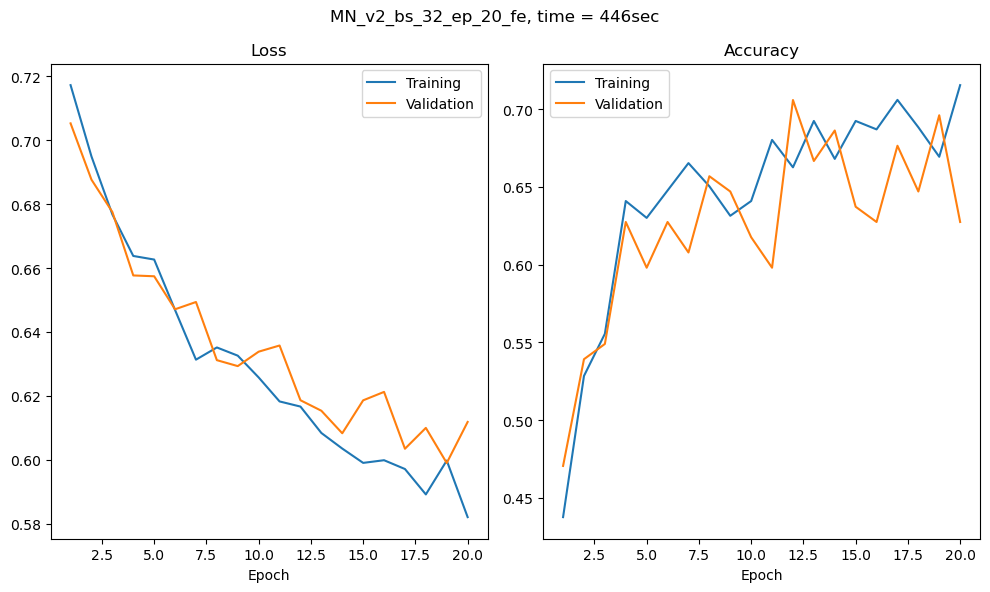

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_l_bs_32_ep_20_fe


Validation accuracy: 0.77


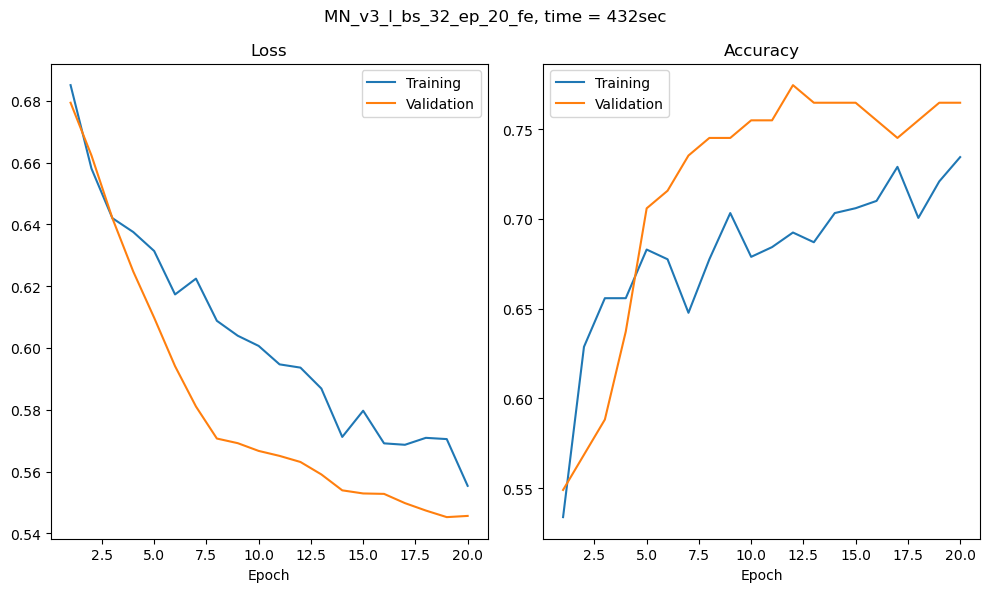

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_l_bs_32_ep_20_fe_dora


Validation accuracy: 0.73


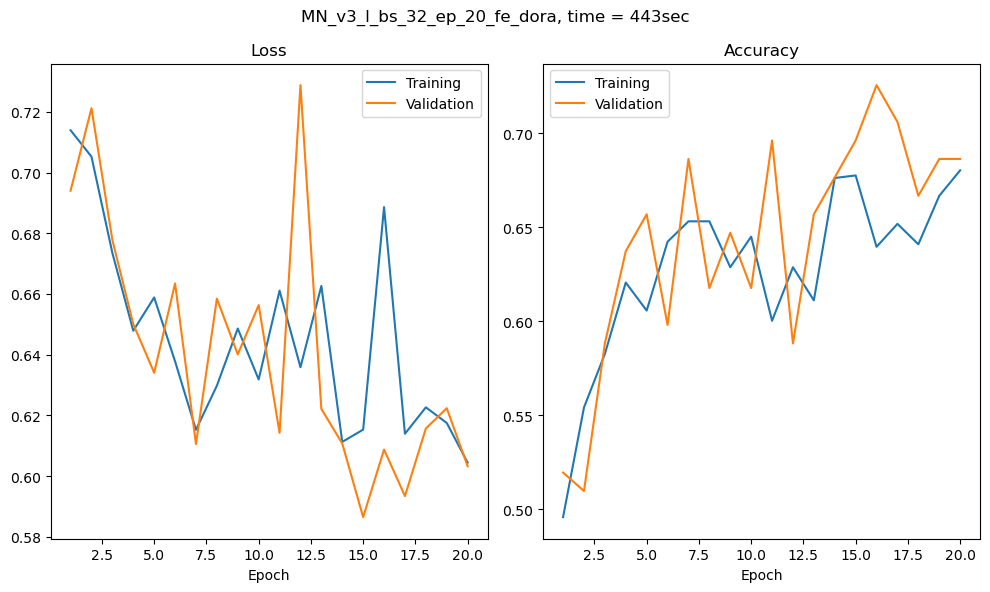

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_l_bs_32_ep_20_fe_lora


Validation accuracy: 0.75


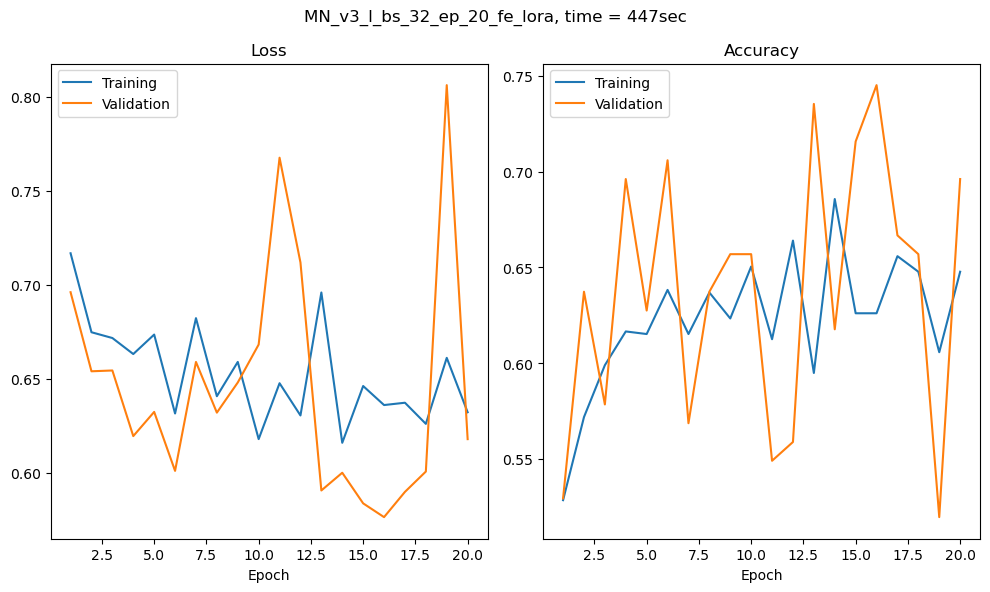

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_l_bs_32_ep_20_ft


Validation accuracy: 0.75


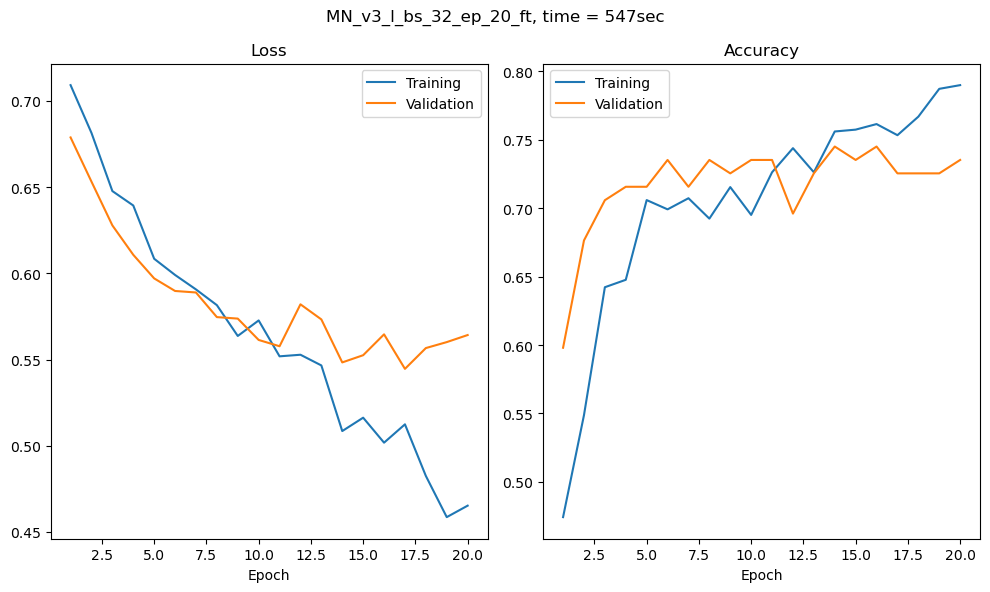

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bs_128_ep_20_fe


Validation accuracy: 0.73


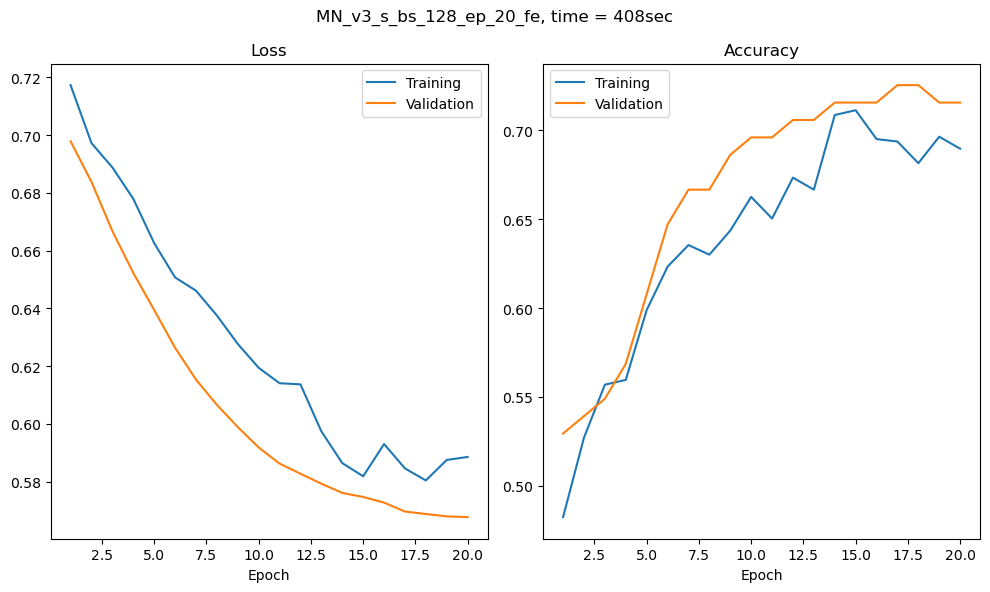

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bs_32_ep_20_fe


Validation accuracy: 0.75


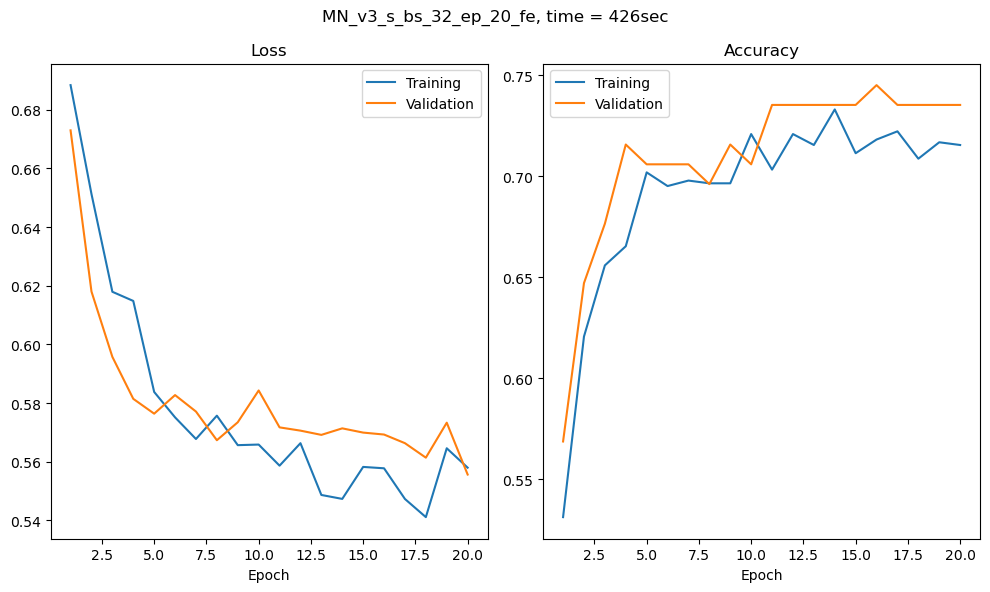

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bs_64_ep_20_fe


Validation accuracy: 0.75


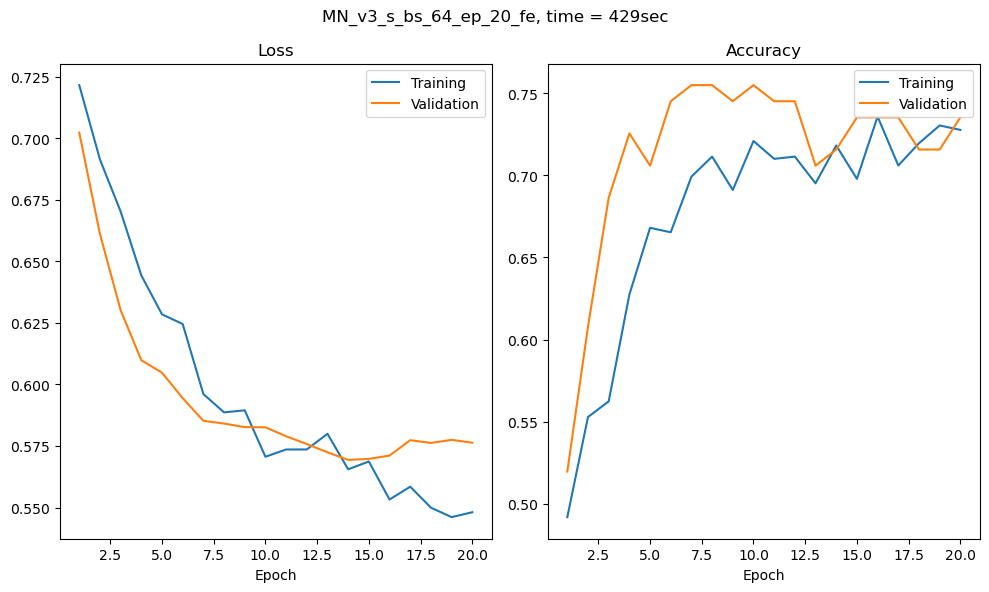

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: RN50_bs_32_ep_20_fe


Validation accuracy: 0.74


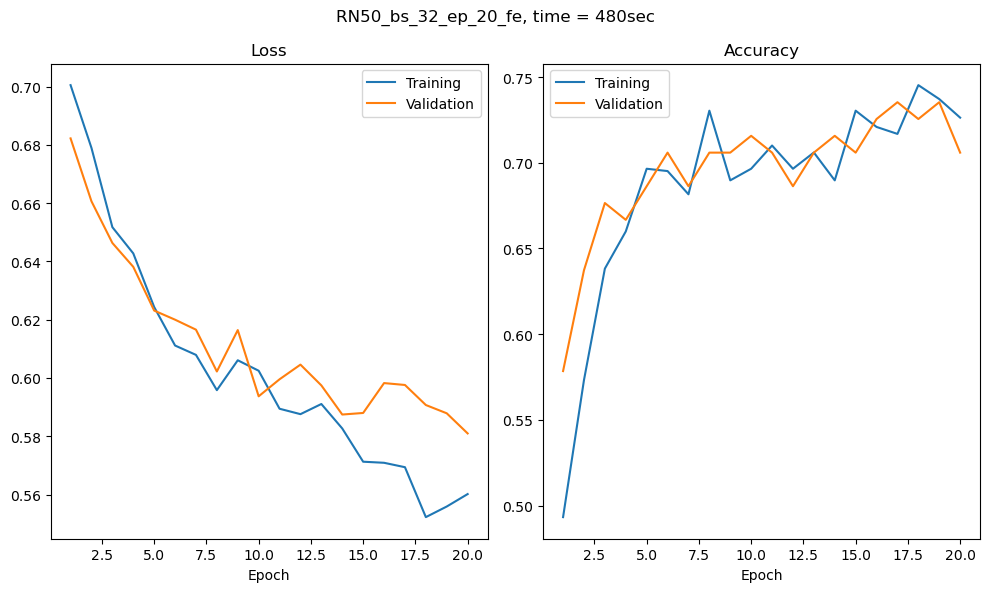

-------------------------------------------------------------------------------------------------------------------


In [22]:
# # loop over all the models and plot the training and validation loss and accuracy
histories_files_names = os.listdir(histories_save_dir)
for history_file_name in histories_files_names:
    print("-------------------------------------------------------------------------------------------------------------------")
    model_descriptor = history_file_name.split("history_")[-1].split('.')[0]
    # remove the last string after the last "_" from model model_descriptor
    model_descriptor_parts = model_descriptor.split("_")[:-1]
    model_descriptor = "_".join(model_descriptor_parts)
    print(f"Model descriptor: {model_descriptor}")
    print("\n")
    # find a history file name which contains the model descriptor  
    # history_file_name = [f for f in os.listdir(histories_save_dir) if model_descriptor in f][0]
    # if history_file_name is None:
    #     print("History file not found")
    #     continue
    model_time = history_file_name.split("_")[-1].split(".")[0]
    history_save_path = os.path.join(histories_save_dir, history_file_name)
    history = pd.read_csv(history_save_path)
    title = model_descriptor + ", time = " + str(model_time) + "sec"
    print(f"Validation accuracy: {max(history['val_acc'].values):.2f}")
    plot_test_results([history["train_loss"], history["train_acc"], history["val_loss"], history["val_acc"]], title)
    
    print("-------------------------------------------------------------------------------------------------------------------")

In [23]:
if val_acc_ft > best_cnn_fe_accuracy:
    best_cnn_model = best_cnn_ft_model
    best_cnn_model_descriptor = best_cnn_ft_model_descriptor
    best_cnn_model_optimizer = best_cnn_ft_model_optimizer
    best_cnn_history = best_cnn_ft_history
    best_cnn_dataloader = best_cnn_ft_dataloader
else:
    best_cnn_model = best_cnn_fe_model
    best_cnn_model_descriptor = best_cnn_fe_model_descriptor
    best_cnn_model_optimizer = best_cnn_fe_model_optimizer
    best_cnn_history = best_cnn_fe_history
    best_cnn_dataloader = best_cnn_fe_dataloader

In [24]:
# load the best model
# best_cnn_model_name = best_cnn_model_descriptor.split("_bs")[0]
# print("The best model is: ", best_cnn_model_descriptor)
# print("Loading the best model...")
# best_cnn_model_save_name = "model_" + best_cnn_model_descriptor + ".pth"
# best_cnn_model_save_path = os.path.join(models_save_dir, best_cnn_model_save_name)
# DoRA = True if "dora" in best_cnn_model_descriptor else False
# LoRA = True if "lora" in best_cnn_model_descriptor else False
# feature_extract = True if "fe" in best_cnn_model_descriptor else False
# best_cnn_model, _ = initialize_model(best_cnn_model_name, num_classes, feature_extract, use_pretrained=True, DoRA=DoRA, LoRA=LoRA)
# best_cnn_model.load_state_dict(torch.load(best_model_save_path))
# best_cnn_model = best_cnn_model.to(device)
# best_cnn_model.eval()

In [25]:
# testing function
def test_model(model, test_loader, criterion, optimizer, num_epochs=25):
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(test_loader.dataset)
    acc = running_corrects.double() / len(test_loader.dataset)

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(loss, acc))

    return loss, acc

Test results for the best model MN_v3_l_bs_32_ep_20_fe
Test Loss: 0.5206 Acc: 0.8564


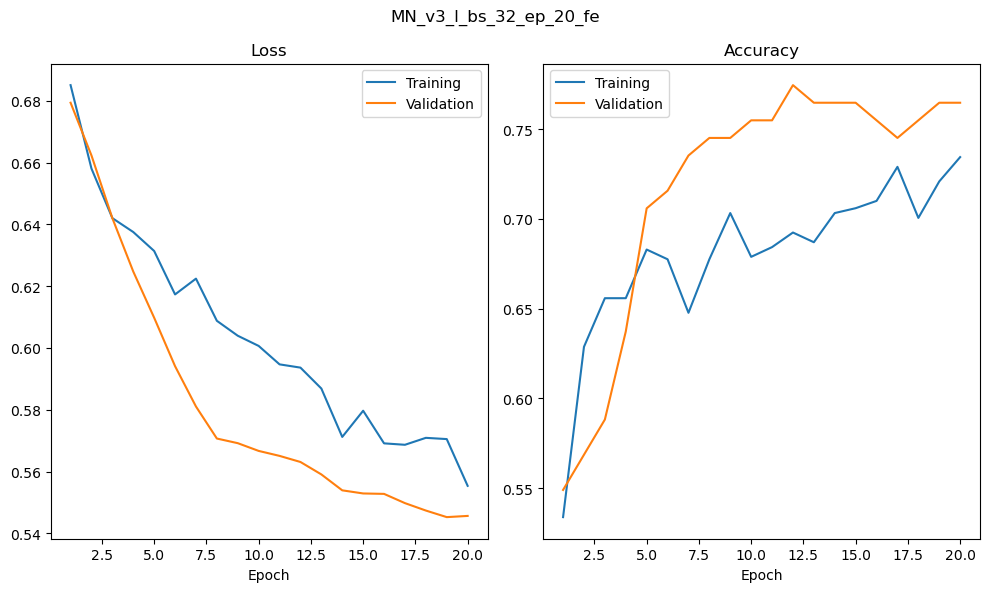

In [26]:
# Evaluate on the test set
criterion = nn.CrossEntropyLoss()
print("Test results for the best model", best_cnn_model_descriptor)
best_model_num_epochs = len(best_cnn_history[0])
test_loss, test_acc = test_model(best_cnn_model, best_cnn_dataloader['test'], criterion, best_cnn_model_optimizer, num_epochs=best_model_num_epochs)

plot_test_results(best_cnn_history, best_cnn_model_descriptor)